### Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Шаг 1. Изучение общей информации

In [1]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
from scipy import stats as st
from IPython.display import Image
import seaborn as sns

%autosave 5

Autosaving every 5 seconds


In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9199,Dino Crisis 3,XB,2003.0,Action,0.08,0.03,0.03,0.00,51.0,4.1,M
10380,Virtual Hydlide,SAT,1995.0,Role-Playing,0.00,0.00,0.11,0.00,NaN,NaN,NaN
16148,Codename: Panzers Phase Two,PC,2005.0,Strategy,0.00,0.01,0.00,0.00,80.0,8.1,T
10930,Rygar: The Battle of Argus,Wii,2008.0,Action,0.09,0.00,0.00,0.01,52.0,7,T
6579,MVP Baseball 2004,GC,2004.0,Sports,0.20,0.05,0.00,0.01,89.0,8.5,E
3201,X-Man,2600,1982.0,Action,0.58,0.04,0.00,0.01,NaN,NaN,NaN
11605,Striker 96,PS,1995.0,Sports,0.04,0.03,0.00,0.01,NaN,NaN,NaN
10428,Kirarin * Revolution: Tsukutte Misechao! Kime ...,DS,2007.0,Simulation,0.00,0.00,0.10,0.00,NaN,NaN,NaN
5716,FIFA Street,PS2,2005.0,Sports,0.15,0.12,0.00,0.04,59.0,7.9,E
2618,Doom,PS,1994.0,Shooter,0.43,0.30,0.00,0.05,NaN,NaN,NaN


In [5]:
df.columns = df.columns.str.lower()

## Шаг 2. Преобразование типов данных.

In [6]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

### Обработка пропусков.

видно, что в name и genre одинаковое количество пропусков - 2. Распечатаем эти две строки, может, это одни и те же строчки?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [8]:
# индексы пустых строк в столбце name:
np.where(pd.isnull(df['name']))

(array([  659, 14244]),)

In [9]:
# распечатываем строки с пустым name
df.loc[[659, 14244]]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


опасения подтвердились. Так как ни жанра, ни названия игры нет, резонно обе строки удалить. С другой стороны, продажи первой - больше двух миллионов долларов. Учитывая, что это сильно больше медианы и среднего арифметического ( в десять раз) удалять как минимум первую строку нельзя, так как сумма большая. С другой стороны, эта игра нам не представляет интереса, так как не указаны никакие характеристики, кроме платформы и сборов.

In [10]:
df.dropna(subset = ['name'], inplace = True)

В столбце с годами релиза есть пропуски. В целом, нам незачем анализ этих строк, если непонятно в каком году игры были выпущены. Однако если эти безвременные игры дали много денег, в этом случае их есть смысл исследовать

In [11]:
# Список индексов строк, имеющих пустые ячейки в столбце с годами релизов.
omission = np.where(pd.isnull(df['year_of_release']))

for i in omission:
    print('Суммарные продажи в Америке всех строк с пропущенным годом релиза -', df.loc[i, 'na_sales'].sum(), 'млн $')
    print('Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Америка - ', df.loc[i, 'na_sales'].sum()/df['na_sales'].sum() *100, '%')
    print('Суммарные продажи в Европе всех строк с пропущенным годом релиза - ', df.loc[i, 'eu_sales'].sum(), 'млн $')
    print('Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Европа - ', df.loc[i, 'eu_sales'].sum() /df['eu_sales'].sum() *100, '%')
    print('Суммарные продажи в Японии всех строк с пропущенным годом релиза - ', df.loc[i, 'jp_sales'].sum(), 'млн $')
    print('Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Япония - ', df.loc[i, 'jp_sales'].sum() / df['jp_sales'].sum() *100, '%')
    print('Суммарные продажи в других странах всех строк с пропущенным годом релиза - ', df.loc[i, 'other_sales'].sum(), 'млн $')
    print('Доля суммарных продаж с неизвестным годом релиза ото всех продаж, другие страны - ', df.loc[i, 'other_sales'].sum() / df['other_sales'].sum() *100, '%')

print()
print()

for i in omission:
    print('Самая высокоприбыльная игра с пропущенным годом релиза в Америке принесла', df.loc[i, 'na_sales'].max(), 'млн $')
    print('Доля самой высокоприбыльной игры в Америке', df.loc[i, 'na_sales'].max()/df['na_sales'].max() *100, '%')
    print('Самая высокоприбыльная игра с пропущенным годом релиза в Европе принесла',df.loc[i, 'eu_sales'].max(), 'млн $')
    print('Доля самой высокоприбыльной игры в Европе', df.loc[i, 'eu_sales'].max() /df['eu_sales'].max() *100, '%')
    print('Самая высокоприбыльная игра с пропущенным годом релиза в Японии принесла',df.loc[i, 'jp_sales'].max(), 'млн $')
    print('Доля самой высокоприбыльной игры в Японии', df.loc[i, 'jp_sales'].max() / df['jp_sales'].max() *100, '%')
    print('Самая высокоприбыльная игра с пропущенным годом релиза в других странах принесла',df.loc[i, 'other_sales'].max(), 'млн $')
    print('Доля самой высокоприбыльной игры в других странах', df.loc[i, 'other_sales'].max() / df['other_sales'].max() *100, '%')

Суммарные продажи в Америке всех строк с пропущенным годом релиза - 55.23 млн $
Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Америка -  1.2550646848021958 %
Суммарные продажи в Европе всех строк с пропущенным годом релиза -  24.069999999999997 млн $
Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Европа -  0.9929294512693159 %
Суммарные продажи в Японии всех строк с пропущенным годом релиза -  10.530000000000001 млн $
Доля суммарных продаж с неизвестным годом релиза ото всех продаж, Япония -  0.8116607828325653 %
Суммарные продажи в других странах всех строк с пропущенным годом релиза -  9.080000000000002 млн $
Доля суммарных продаж с неизвестным годом релиза ото всех продаж, другие страны -  1.1475658460138518 %


Самая высокоприбыльная игра с пропущенным годом релиза в Америке принесла 4.26 млн $
Доля самой высокоприбыльной игры в Америке 10.29980657640232 %
Самая высокоприбыльная игра с пропущенным годом релиза в Европе принесла 2.36 млн $
Доля

In [12]:
df.dropna(subset = ['year_of_release'], inplace = True)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Теперь стоит посмотреть насколько сильно мы повредили датасет и потеряли ли строчки с большой прибылью. Сравним имеющийся df с изначальным df, для этого загрузим данные и назовем датасет old_df

In [13]:
old_df = pd.read_csv('/datasets/games.csv')

добавим в old_df и в df по новому столбцу - суммарный профит по всем локациям

In [14]:
df['total_profit'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [15]:
old_df['total_profit'] = old_df['NA_sales'] + old_df['EU_sales'] + old_df['JP_sales'] + old_df['Other_sales']

In [16]:
print('После обработки сумма профита сотни топовых по профиту игр:', df['total_profit'].sort_values(ascending=False).head(100).sum())
print('До обработки сумма профита сотни топовых по профиту игр:', old_df['total_profit'].sort_values(ascending=False).head(100).sum())

После обработки сумма профита сотни топовых по профиту игр: 1458.89
До обработки сумма профита сотни топовых по профиту игр: 1458.89


При этом самые топовые по прибыли игры тоже особо не поменялись. Соответственно, изменения принимаем, идём дальше

## Шаг 3. Исследовательский анализ данных


Text(0, 0.5, 'Встречаемость')

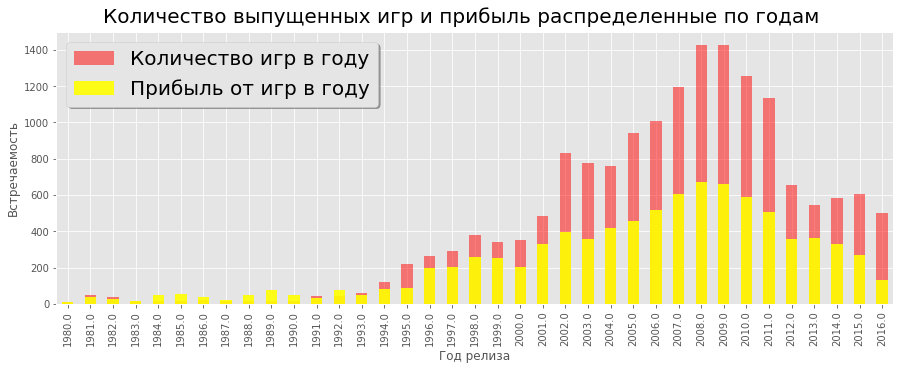

In [17]:
plt.figure(figsize=(15, 5)).suptitle('Количество выпущенных игр и прибыль распределенные по годам', fontsize=20, y=0.95, x=0.5)

df.groupby('year_of_release')['total_profit'].count().plot( kind='bar', color='red' , alpha=0.5, label='Количество игр в году')
df.groupby('year_of_release')['total_profit'].sum().plot( kind='bar', color='yellow', alpha=0.9, label='Прибыль от игр в году')
plt.legend(shadow = True, fontsize = 20)

plt.xlabel('Год релиза')
plt.ylabel('Встречаемость')

На графике видны два тренда : до 2008-2009 года восходящий, после 2008-2009 - нисходящий. При этом внутри временного промежутка 2008-2009 - 2016 тоже есть условно два своих тренда. В 2012м году игр стало выпускаться резко меньше, а суммарная прибыль упала не слишком сильно. Это значит, что игры 2012-2016 годов в среднем сильно прибыльнее, чем игры 2009-2012, в связи с чем считаю правильным принять за актуальный период отрезок 2012-2016

Text(0, 0.5, 'млн $')

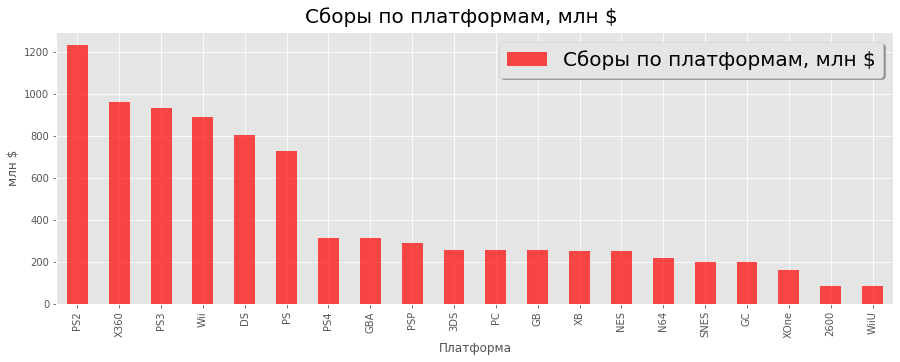

In [18]:
plt.figure(figsize=(15, 5)).suptitle('Сборы по платформам, млн $', fontsize=20, y=0.95, x=0.5)


df.groupby('platform')['total_profit'].sum().sort_values(ascending=False).head(20).plot(kind='bar', alpha=0.7, color='red', label='Сборы по платформам, млн $')
plt.legend(shadow = True, fontsize = 20)
plt.xlabel('Платформа')
plt.ylabel('млн $')

In [19]:
years_platforms_profit = pd.DataFrame(df.groupby(['year_of_release', 'platform'])['total_profit'].sum())

In [20]:
years_platforms_profit = years_platforms_profit.query('platform == "PS2" | platform =="X360" | platform == "PS3" | platform =="Wii" | platform == "DS" | platform =="PS"').reset_index()

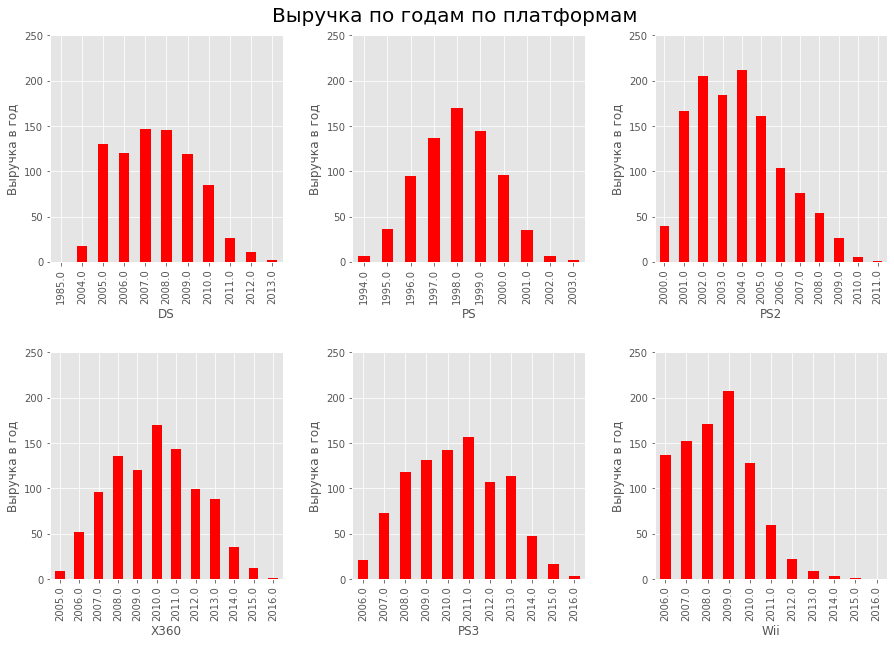

In [21]:
plt.figure(figsize=(15, 10)).suptitle('Выручка по годам по платформам', fontsize=20, y=0.92, x=0.5)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

def test(i, plat):
    plt.subplot(2, 3, i)
    years_platforms_profit.query('platform == @plat').groupby('year_of_release')['total_profit'].sum().plot( kind='bar', color='red')
    plt.xlabel(plat)
    plt.ylabel('Выручка в год')
    plt.ylim(0, 250)

def test1():
    i = 1
    for word in years_platforms_profit['platform'].unique():
        test(i, word)
        i += 1
        
test1()

#### За какой характерный срок появляются новые и исчезают старые платформы?

В среднем набирают популярность игры 4 года, держатся на рынке и пропадают в течение 5 лет

На графике видны два тренда : до 2008-2009 года восходящий, после 2008-2009 - нисходящий. При этом внутри временного промежутка 2008-2009 - 2016 тоже есть условно два своих тренда. В 2012м году игр стало выпускаться резко меньше, а суммарная прибыль упала не слишком сильно. Это значит, что игры 2012-2016 годов в среднем сильно прибыльнее, чем игры 2009-2012.

### Чтобы это учесть, в качестве актуального периода возьмём промежуток 2012-2016


In [22]:
actual_data = df.query('year_of_release >= 2012')

In [23]:
actual_platforms = pd.DataFrame(actual_data.groupby(['platform','year_of_release'])['total_profit'].sum()).reset_index(drop=False)

In [24]:
def print_actual_platforms(i, plat):
    plt.subplot(4, 3, i)
    actual_platforms.query('platform == @plat').groupby('year_of_release')['total_profit'].sum().plot( kind='bar', color='red')
    plt.xlabel(plat)
    plt.ylabel('Сборы, млн $')
    plt.ylim(0, 120)
def def_for_print_actual_platforms():
    i = 1
    for word in actual_platforms['platform'].unique():
        print_actual_platforms(i, word)
        i += 1

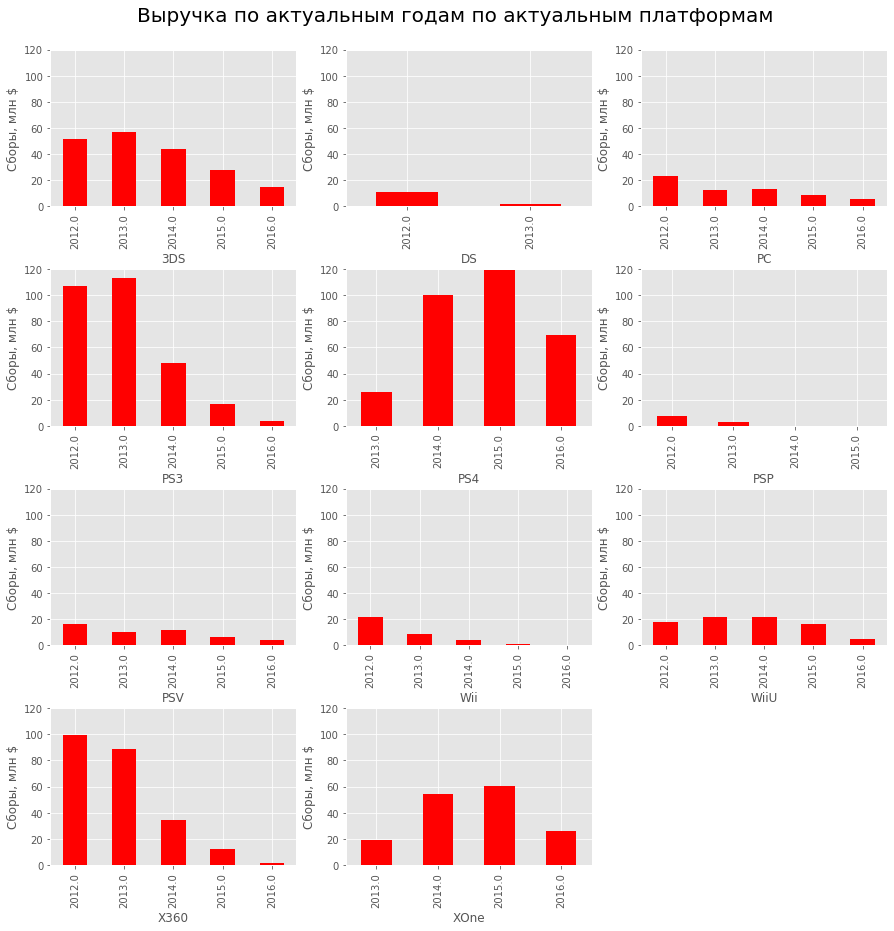

In [25]:
plt.figure(figsize=(15, 15)).suptitle('Выручка по актуальным годам по актуальным платформам', fontsize=20, y=0.92, x=0.5)
plt.subplots_adjust(hspace=0.4)


def_for_print_actual_platforms()

Четко видно, что наиболее подходящие нам по сборам платформы - это **PS4**, **XOne**

In [26]:
actual_data_actual_platforms = actual_data.query('platform == "PS4" | platform == "XOne"')[['platform', 'total_profit']]
actual_data_actual_platforms.head(4)

,platform,total_profit
31,PS4,14.63
42,PS4,12.62
77,PS4,8.58
87,PS4,7.98


Text(0.5, 1, 'Значения, воспринимаемые боксплотом как выбросы')

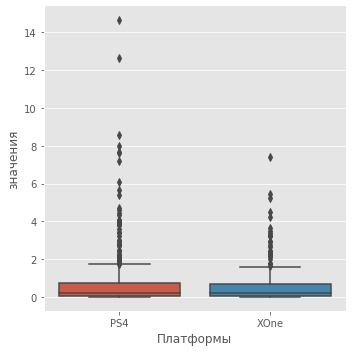

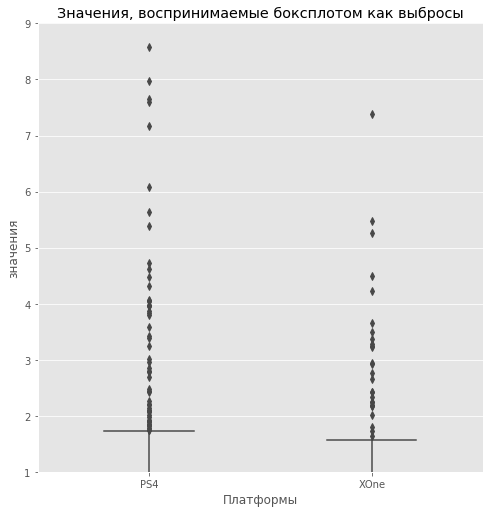

In [27]:
sns.catplot(x='platform', y='total_profit', data=actual_data_actual_platforms, kind='box', height=5)
plt.xlabel('Платформы')
plt.ylabel('значения')

sns.catplot(x='platform', y='total_profit', data=actual_data_actual_platforms, kind='box', height=7)
plt.ylim(1, 9)
plt.xlabel('Платформы')
plt.ylabel('значения')
plt.title('Значения, воспринимаемые боксплотом как выбросы')

In [28]:
print('Медиана прибыли по PS4', actual_data_actual_platforms.query('platform=="PS4"')['total_profit'].median())
print('Медиана прибыли по XOne', actual_data_actual_platforms.query('platform=="XOne"')['total_profit'].median())
print()
print('Среднее прибыли по PS4', actual_data_actual_platforms.query('platform=="PS4"')['total_profit'].mean())
print('Среднее прибыли по XOne', actual_data_actual_platforms.query('platform=="XOne"')['total_profit'].mean())

Медиана прибыли по PS4 0.2
Медиана прибыли по XOne 0.22

Среднее прибыли по PS4 0.8013775510204081
Среднее прибыли по XOne 0.6450202429149797


**Вывод по боксплотам.**

Во-первых, стоит сказать, что выручку стоит распределить условно на два типа - это совсем далекие выбросы, то есть невероятно прибыльные игры и большинство игр. Рассматривать боксплоты будем в соответствии с этой градацией.

1. Если анализировать наиболее далекие выбросы, обозначающие крайне успешные игры, их больше у PS4. Однако полагаться на них рискованно - в штуках их у PS4 две, а у XOne - 1. А рассматриваем мы больше двух тысяч игр, и в их распределении три крайне успешные игры очень легко теряются
2. Виду этого более рационально смотреть на распределение большинства игр. И, судя по самому ящику с усами, выручка у PS4 несильно, но больше выручки на XOne и это важно учесть - такое распределение актуально для *большинства* игр, а значит, скорее всего случится и с выходом новых игр и дальше

Медианы примерно равны, а вот среднее арифметическое больше у PS4 на 24%. 

Учитывая и распределение большинства игр и выбросов, платформа PS4 становится более приоритетной. 

**Взаимосвязь оценок пользователей и критиков со сборами**

ДЛЯ PS4:

In [29]:
actual_data_PS4 = actual_data.query('platform =="PS4"')[['platform', 'critic_score', 'user_score', 'total_profit']]
actual_data_PS4.dropna(subset = ['critic_score'], inplace=True)
actual_data_PS4.info()

actual_data_PS4['critic_score'] = round(actual_data_PS4['critic_score'],-1)
actual_data_PS4['user_score'] = round(actual_data_PS4['user_score'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 42 to 16530
Data columns (total 4 columns):
platform        252 non-null object
critic_score    252 non-null float64
user_score      249 non-null float64
total_profit    252 non-null float64
dtypes: float64(3), object(1)
memory usage: 9.8+ KB


Text(9.924999999999997, 0.5, 'Прибыль')

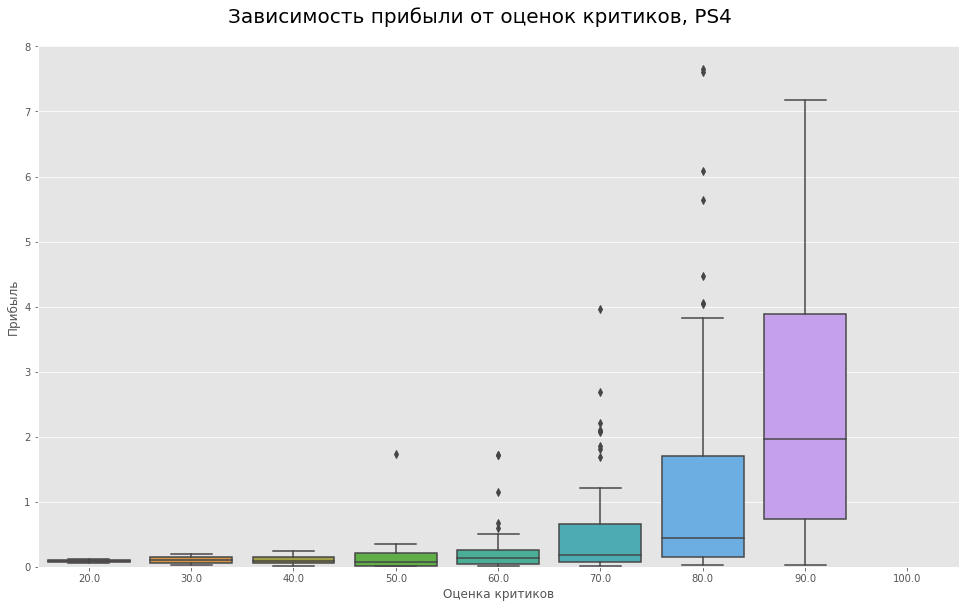

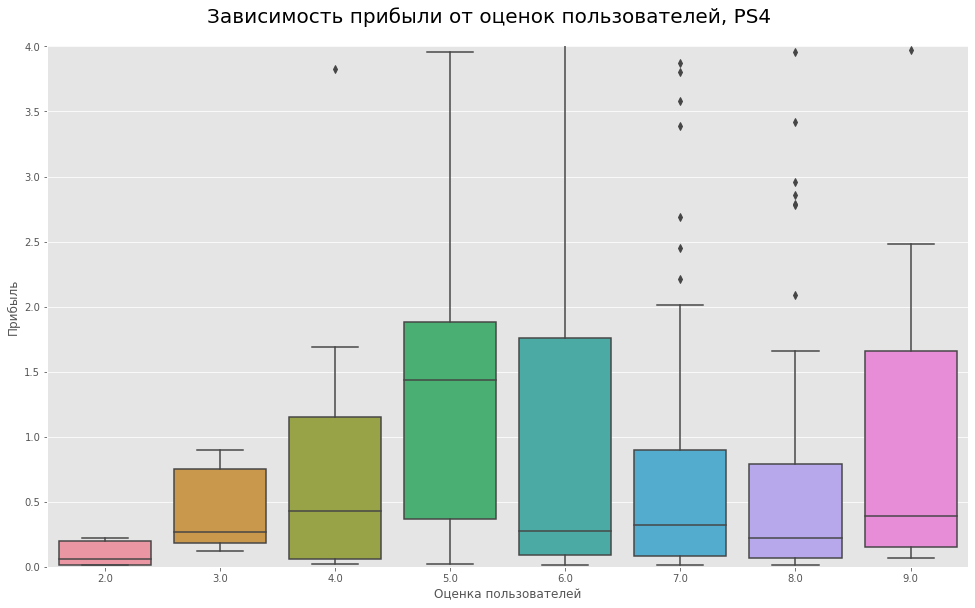

In [30]:
sns.catplot(x='critic_score', y='total_profit', data=actual_data_PS4, kind='box', aspect=1.7, height=8).fig.suptitle('Зависимость прибыли от оценок критиков, PS4', fontsize=20, y=1.05 , x=0.5)
plt.ylim(0, 8)
plt.xlabel('Оценка критиков')
plt.ylabel('Прибыль')

sns.catplot(x='user_score', y='total_profit', data=actual_data_PS4, kind='box', aspect=1.7, height=8).fig.suptitle('Зависимость прибыли от оценок пользователей, PS4', fontsize=20, y=1.05 , x=0.5)
plt.ylim(0, 4,5)
plt.xlabel('Оценка пользователей')
plt.ylabel('Прибыль')

In [31]:
print('Корреляция между оценками пользователей и стоимостью =', actual_data_PS4['user_score'].corr(actual_data_PS4['total_profit']), 'взаимосвязь отсутствует')
print('Корреляция между оценками критиков и стоимостью =', actual_data_PS4['critic_score'].corr(actual_data_PS4['total_profit']), 'взаимосвязь положительная, слабая')

Корреляция между оценками пользователей и стоимостью = -0.05285529781830357 взаимосвязь отсутствует
Корреляция между оценками критиков и стоимостью = 0.38845530110048737 взаимосвязь положительная, слабая


In [32]:
print('Корреляция между оценками критиков и стоимостью, где оценка >=70 =', actual_data_PS4.query('critic_score >= 70')['critic_score'].corr(actual_data_PS4.query('critic_score >= 70')['total_profit']), 'взаимосвязь положительная, слабая')

Корреляция между оценками критиков и стоимостью, где оценка >=70 = 0.4178820781573044 взаимосвязь положительная, слабая


Для PS4:

1. Разница в выручке при оценке критиков до 70 существенно не различаются
2. Если оценка критиков от 70, то чем она больше, тем больше игра приносит прибыли, хотя корреляция по Пирсону не сильно отличается от корреляции по всем оценкам критиков
3. Корреляции между оценками пользователей и выручкой просто нет, её даже отрицательной слабой назвать крайне сложно. 

ДЛЯ XONE:

In [33]:
actual_data_XOne = actual_data.query('platform =="XOne"')[['platform', 'critic_score', 'user_score', 'total_profit']]
actual_data_XOne.dropna(subset = ['critic_score'], inplace=True)
actual_data_XOne.info()

actual_data_XOne['critic_score'] = round(actual_data_XOne['critic_score'],-1)
actual_data_XOne['user_score'] = round(actual_data_XOne['user_score'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 165 to 16660
Data columns (total 4 columns):
platform        169 non-null object
critic_score    169 non-null float64
user_score      165 non-null float64
total_profit    169 non-null float64
dtypes: float64(3), object(1)
memory usage: 6.6+ KB


Text(16.299999999999997, 0.5, 'Прибыль')

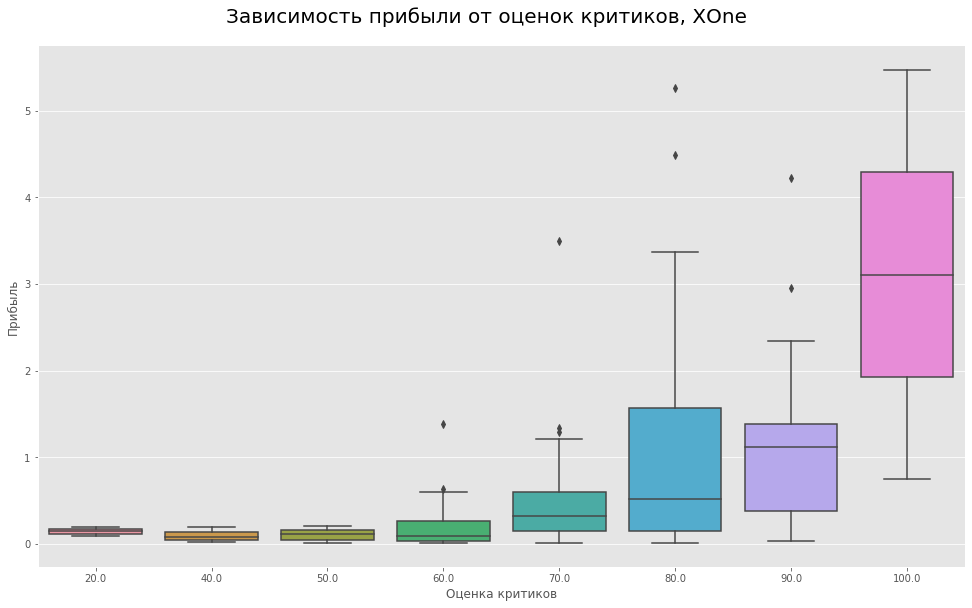

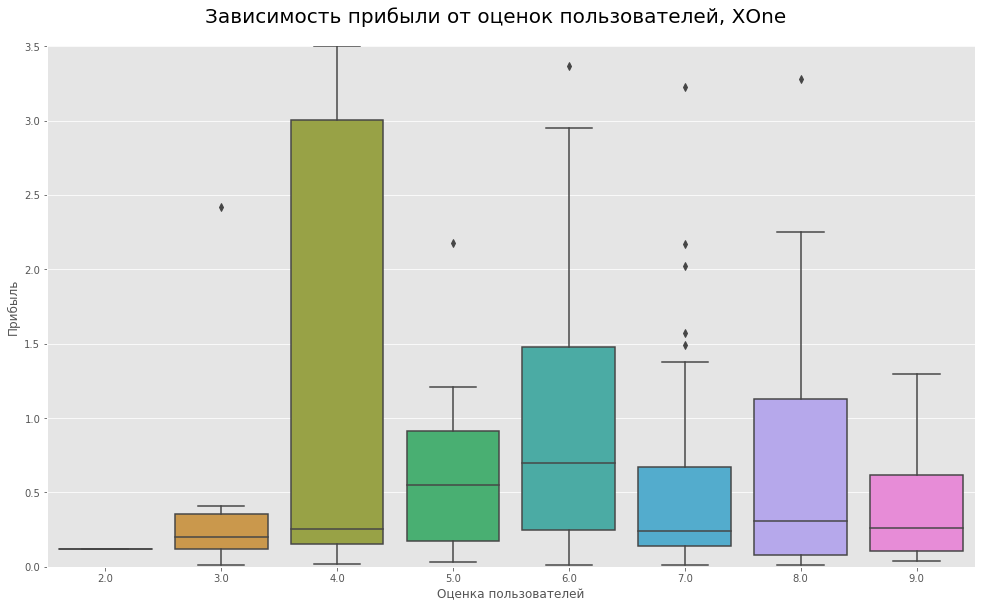

In [34]:
sns.catplot(x='critic_score', y='total_profit', data=actual_data_XOne, kind='box', aspect=1.7, height=8).fig.suptitle('Зависимость прибыли от оценок критиков, XOne', fontsize=20, y=1.05 , x=0.5)
plt.xlabel('Оценка критиков')
plt.ylabel('Прибыль')

sns.catplot(x='user_score', y='total_profit', data=actual_data_XOne, kind='box', aspect=1.7, height=8).fig.suptitle('Зависимость прибыли от оценок пользователей, XOne', fontsize=20, y=1.05 , x=0.5)
plt.ylim(0, 3.5)
plt.xlabel('Оценка пользователей')
plt.ylabel('Прибыль')

In [35]:
print('Корреляция между оценками пользователей и стоимостью', actual_data_XOne['user_score'].corr(actual_data_XOne['total_profit']), 'взаимосвязь отрицательная, слабая')
print('Корреляция между оценками критиков и стоимостью', actual_data_XOne['critic_score'].corr(actual_data_XOne['total_profit']), 'взаимосвязь положительная, слабая')

Корреляция между оценками пользователей и стоимостью -0.1069648304783788 взаимосвязь отрицательная, слабая
Корреляция между оценками критиков и стоимостью 0.3956969852663961 взаимосвязь положительная, слабая


In [36]:
print('Корреляция между оценками критиков и стоимостью, где оценка >=70 =', actual_data_XOne.query('critic_score >= 70')['critic_score'].corr(actual_data_XOne.query('critic_score >= 70')['total_profit']), 'взаимосвязь положительная, слабая')

Корреляция между оценками критиков и стоимостью, где оценка >=70 = 0.2998266789388778 взаимосвязь положительная, слабая


Для XOne:

1. Разница в выручке при оценке критиков до 70 существенно не различаются
2. Если оценка критиков от 70, то чем она больше, тем больше игра приносит прибыли, хотя корреляция по Пирсону уменьшилась на треть. 
3. Корреляции между оценками пользователей и выручкой также нет. 

Примечательно, что корреляции между оценками пользователей и выручкой на обеих платформах разные и отличаются в два раза, а корреляции между оценками **критиков** и выручкой невероятно близки.

Посмотрим на такое распределение для другой платформы - 3DS, так как из оставшихся она держится на рынке сильнее других

Корреляция между оценками пользователей и стоимостью 0.20486578974237185 взаимосвязь положительная, слабая
Корреляция между оценками критиков и стоимостью 0.35546691570185895 взаимосвязь положительная, слабая


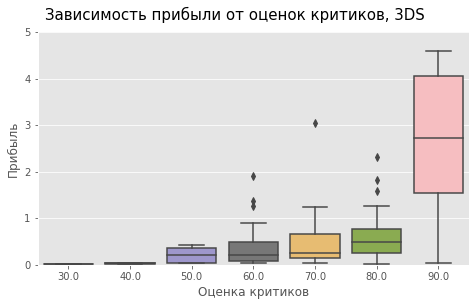

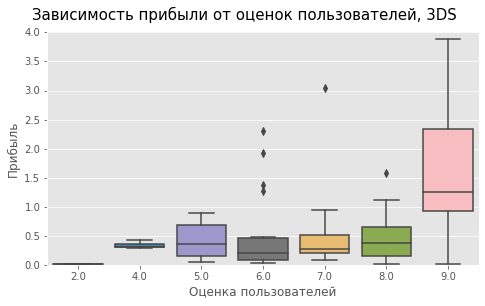

In [37]:
actual_data_3DS = actual_data.query('platform =="3DS"')[['platform', 'critic_score', 'user_score', 'total_profit']]
actual_data_3DS.dropna(subset = ['critic_score'], inplace=True)
actual_data_3DS['critic_score'] = round(actual_data_3DS['critic_score'],-1)
actual_data_3DS['user_score'] = round(actual_data_3DS['user_score'])

sns.catplot(x='critic_score', y='total_profit', data=actual_data_3DS, kind='box', aspect=1.7, height=4).fig.suptitle('Зависимость прибыли от оценок критиков, 3DS', fontsize=15, y=1.05 , x=0.5)
plt.xlabel('Оценка критиков')
plt.ylabel('Прибыль')
plt.ylim(0, 5)

sns.catplot(x='user_score', y='total_profit', data=actual_data_3DS, kind='box', aspect=1.7, height=4).fig.suptitle('Зависимость прибыли от оценок пользователей, 3DS', fontsize=15, y=1.05 , x=0.5)
plt.ylim(0, 4)
plt.xlabel('Оценка пользователей')
plt.ylabel('Прибыль')


print('Корреляция между оценками пользователей и стоимостью', actual_data_3DS['user_score'].corr(actual_data_3DS['total_profit']), 'взаимосвязь положительная, слабая')
print('Корреляция между оценками критиков и стоимостью', actual_data_3DS['critic_score'].corr(actual_data_3DS['total_profit']), 'взаимосвязь положительная, слабая')

В данном случае выручка начинает расти с оценки 50, а не с 70, однако этого недостаточно, чтобы воспринимать платформу 3DS как актуальную

**О прибыльности жанров**

In [38]:
actual_data.query('platform=="PS4" | platform=="XOne"').groupby('genre')['total_profit'].sum().sort_values(ascending=False)

genre
Shooter         148.89
Action          133.41
Sports           82.35
Role-Playing     39.54
Racing           21.93
Misc             15.62
Fighting         11.10
Adventure         9.02
Platform          8.62
Simulation        1.92
Strategy          1.04
Puzzle            0.02
Name: total_profit, dtype: float64

Два крайне прибыльных жанра - шутер и экшн, потом - спортивные игры. Наименее прибыльный жанр - пазлы, отличающийся по выручке в 52 раза в сравнении со вторым по наименьшей прибыльностью - стратегиями.

Text(0, 0.5, 'млн $')

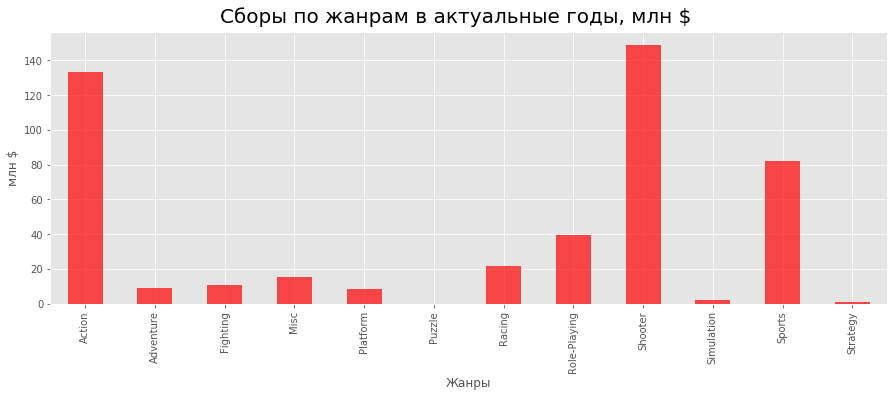

In [39]:
plt.figure(figsize=(15, 5)).suptitle('Сборы по жанрам в актуальные годы, млн $', fontsize=20, y=0.95, x=0.5)
actual_data.query('platform=="PS4" | platform=="XOne"').groupby('genre')['total_profit'].sum().plot(kind='bar', alpha=0.7, color='red')
plt.xlabel('Жанры')
plt.ylabel('млн $')

Добавим в таблицы столбец с коэффициентом, обозначающим отношение выручки конкретной платформы к продажам самой низкоокупаемой платформы. Таким образом, мы будем судить о платформах относительно друг друга и измерять их в том, насколько они больше самой низкой выручки. Этот метод на мой взгляд более корректен, чем сравнение с общими продажами в мире в процентах, потому что в данном случае речь идёт о сравнении **конкретных** пяти платформах и сравнивать их cледует **между собой**.

In [40]:
na_actual = pd.DataFrame(actual_data.query('na_sales > 0')[['name','platform', 'genre', 'na_sales','rating']].groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)
eu_actual = pd.DataFrame(actual_data.query('eu_sales > 0')[['name','platform', 'genre', 'eu_sales','rating']].groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)
jp_actual = pd.DataFrame(actual_data.query('jp_sales > 0')[['name','platform', 'genre', 'jp_sales','rating']].groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)

na_genres = pd.DataFrame(actual_data.query('na_sales > 0').groupby(['genre'])['na_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)
eu_genres = pd.DataFrame(actual_data.query('eu_sales > 0').groupby(['genre'])['eu_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)
jp_genres = pd.DataFrame(actual_data.query('jp_sales > 0').groupby(['genre'])['jp_sales'].sum().sort_values(ascending=False).head(5)).reset_index(drop=False)

na_rating = pd.DataFrame(actual_data.query('na_sales > 0').groupby(['rating'])['na_sales'].sum().sort_values(ascending=False)).reset_index(drop=False)
eu_rating = pd.DataFrame(actual_data.query('eu_sales > 0').groupby(['rating'])['eu_sales'].sum().sort_values(ascending=False)).reset_index(drop=False)
jp_rating = pd.DataFrame(actual_data.query('jp_sales > 0').groupby(['rating'])['jp_sales'].sum().sort_values(ascending=False)).reset_index(drop=False)

In [41]:
def pop_plats(df, column, x):
    list = []
    for i in range(0, x+1):
        list.append(df[column][i] / df[column][x])
        i += 1
    pd.Series(list)
    df['coefficient'] = list
    df['coefficient'] = round(df['coefficient'], 2)
    
pop_plats(na_actual, 'na_sales', 4)
pop_plats(eu_actual, 'eu_sales', 4)
pop_plats(jp_actual, 'jp_sales', 4)

In [42]:
na_actual

,platform,na_sales,coefficient
0,X360,140.05,2.53
1,PS4,108.74,1.97
2,PS3,103.38,1.87
3,XOne,93.12,1.68
4,3DS,55.31,1.00


In [43]:
eu_actual

,platform,eu_sales,coefficient
0,PS4,141.09,3.31
1,PS3,106.86,2.51
2,X360,74.52,1.75
3,XOne,51.59,1.21
4,3DS,42.64,1.00


In [44]:
jp_actual

,platform,jp_sales,coefficient
0,3DS,87.79,6.75
1,PS3,35.29,2.71
2,PSV,21.04,1.62
3,PS4,15.96,1.23
4,WiiU,13.01,1.00


Стоит сказать, что в Японии особняком стоит 3DS - почти монополист, который делает выручку в 12 с половиной раз больше, чем конкуренты. В Европе наиболее популярны серии PS 3 и 4, в Америке - PS4 и X360.

In [45]:
pop_plats(na_genres, 'na_sales', 4)
pop_plats(eu_genres, 'eu_sales', 4)
pop_plats(jp_genres, 'jp_sales', 4)

In [46]:
na_genres

,genre,na_sales,coefficient
0,Action,177.84,4.66
1,Shooter,144.77,3.79
2,Sports,81.53,2.13
3,Role-Playing,64.00,1.68
4,Misc,38.19,1.00


In [47]:
eu_genres

,genre,eu_sales,coefficient
0,Action,159.34,5.84
1,Shooter,113.47,4.16
2,Sports,69.09,2.53
3,Role-Playing,48.53,1.78
4,Racing,27.29,1.00


In [48]:
jp_genres

,genre,jp_sales,coefficient
0,Role-Playing,65.44,6.93
1,Action,52.80,5.59
2,Misc,12.86,1.36
3,Simulation,10.41,1.10
4,Fighting,9.44,1.00


Список наиболее популярных игр в Америке и Европе одинаков за тем исключением, что в Европе в шутеры и экшены играют одинаково часто, в отличие от Америки. Примечательно, что в целом в Японии играют в другие игры - 3 игры из 5ти в Японии актуальны сугубо для Японии в данных примерах. Рынок в Японии, вероятно, крайне специфичен, но есть разница и между Америкой с Европой: выходя на рынок Америки, шутеры приоритетнее.

In [49]:
na_rating

,rating,na_sales
0,M,231.57
1,E,114.37
2,E10+,75.70
3,T,66.02


In [50]:
eu_rating

,rating,eu_sales
0,M,193.96
1,E,113.03
2,E10+,55.37
3,T,52.96


In [51]:
jp_rating

,rating,jp_sales
0,E,28.33
1,T,26.02
2,M,21.20
3,E10+,8.19


Вполне наглядно, что игры с рейтингом Е продаются лучше, чем игры с рейтингом Т. Также видно, что в двух случаях из двух игры с рейтингом М продаются лучше, чем игры с рейтингом Е с серьезным отрывом - в 1.5-2 раза больше прибыли. Насчет рейтинга Е10+ неоднозначно, но игры с этим рейтингом продаются примерно также, как и игры с рейтингом Т.

 ### Проверка гипотез о том, что:
 
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверка гипотезы №1. Сформулируем гипотезу H₀ так, чтобы использовать знак равенства.

**Нулевая гипотеза H₀**: Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**

**Альтернативная гипотеза H₁**: Средние пользовательские рейтинги платформ Xbox One и PC **разные**

Так как мы сравниваем два средних из двух выборок, из библиотеки scipy подбираем метод ttest_ind(), если обе выборки имеют нормальное распределение. Если хоть одна из двух выборок нормального распределения не имеет, используем метод Манна-Уитни. Чтобы понять нормальное распределение имеют выборки или нет, используем для обеих критерий Шапиро.

In [52]:
# АНАЛИЗИРУЕМ НА НОРМАЛЬНОСТЬ ПО КРИТЕРИЮ ШАПИРО 

alpha = 0.05

# Проверим на нормальность:
def is_normal(df, plat, column):
    results = st.shapiro(
        df.query('platform == @plat')[column].dropna().reset_index(drop=True))
    if (results[1] < alpha):
        print('Распределение не нормальное')
    else:
        print("Распределение нормальное")     

is_normal(actual_data, 'XOne', 'user_score')
is_normal(actual_data, 'PC', 'user_score') 

Распределение не нормальное
Распределение не нормальное


Так как оба распределения ненормальны, для проверки гипотез возьмем критерий Манна-Уитни.

In [53]:
user_score_for_XOne = actual_data.query('platform =="XOne"')['user_score'].dropna()
user_score_for_PC = actual_data.query('platform =="PC"')['user_score'].dropna()

In [54]:
results = st.mannwhitneyu(
    user_score_for_XOne, 
    user_score_for_PC)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые")   

p-значение:  0.4324531487349707
Не получилось отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Можно сказать, что люди оценивают игры на платформе Xbox One и PC примерно одинаково.

Проверка гипотезы №2. Сформулируем гипотезу H₀ так, чтобы использовать знак равенства.

**Нулевая гипотеза H₀**: Средние пользовательские рейтинги жанров Action и Sports **одинаковые**.

**Альтернативная гипотеза H₁**: Средние пользовательские рейтинги жанров Action и Sports **разные**

Так как мы сравниваем два средних из двух выборок, из библиотеки scipy подбираем метод ttest_ind(), если обе выборки имеют нормальное распределение. Если хоть одна из двух выборок нормального распределения не имеет, используем метод Манна-Уитни. Чтобы понять нормальное распределение имеют выборки или нет, используем для обеих критерий Шапиро.

In [55]:
def is_normal(df, gen, column):
    results = st.shapiro(
        df.query('genre == @gen')[column].dropna().reset_index(drop=True))
    if (results[1] < alpha):
        print('Распределение не нормальное')
    else:
        print("Распределение нормальное")     

is_normal(actual_data, 'Action', 'user_score')
is_normal(actual_data, 'Sports', 'user_score') 

Распределение не нормальное
Распределение не нормальное


Так как оба распределения ненормальны, для проверки гипотез возьмем критерий Манна-Уитни.

In [56]:
user_score_for_Action = actual_data.query('genre =="Action"')['user_score'].dropna()
user_score_for_Sports = actual_data.query('genre =="Sports"')['user_score'].dropna()

In [57]:
results = st.mannwhitneyu(
    user_score_for_Action, 
    user_score_for_Sports)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые.")
else:
    print("Не получилось отвергнуть нулевую ")   

p-значение:  5.714382600964342e-24
Отвергаем нулевую гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые.


Средние пользовательские рейтинги жанров Action и Sports разнятся, но это не даст нам существенной помощи в анализе, потому что мы уже посчитали насколько прибылен тот или иной жанр в зависимости от локации

## Итог.

В целом, нас интересуют преимущественно платформы PS4 и Xbox One. Если нацелены на рынок америкнский, лучше PS4,  если на европейский тоже PS4, если на японский - 3DS, но с учетом, что игра не будет популярна нигде, кроме Японии, то есть суммарно лучше склонить к PS4.

Если целевая аудитория в Америке и Европе, по жанрам лучше экшн, шутер, спортивные. В японии абсолютный лидер -  Role-play, но в Америке и Европе Role-play распространен меньше.

Для аудитории в Америке и Европе бесспорно лучший возрастной порог М - "материалы игры не подходят для подростков младше 17 лет", далее Е - "Для всех". В японии иная ситуация:  преимущественно нет данных, а по тем, что есть, лучше рейтинг Е. 


**Большая часть выводов может быть сделана, зная целевую аудиторию проекта.** Если она не выбрана, то эффективнее выбрать Америку и Европу - часто интересы аудитории совпадают. При этом выручка за актуальный период в Америке составила 237 млн $, в Европе - 192. Суммарно это 429 млн, в противовес 44 в Японии:

In [58]:
actual_data[['na_sales', 'eu_sales','jp_sales']].sum()

na_sales    590.97
eu_sales    506.82
jp_sales    192.58
dtype: float64